In [1]:
from torch_geometric.data import Data
from tensordict import TensorDict
import torch_geometric.nn as gnn
import torch
import torch.nn as nn
import torch_geometric
import torch.functional as F
import torchrl.envs
import torchrl.modules
import torchrl.objectives
import networkx as nx
import pyvis
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import runner

from pathlib import Path
from typing import Protocol, cast
import enum
import dataclasses
import pickle
import asyncio
import random
import json
import logging

In [2]:
logger = logging.getLogger("notebook")
logger.setLevel(logging.DEBUG)
logging.basicConfig(level=logging.DEBUG)

In [3]:
from primitives import Clause

class NodeType(enum.Enum):
    VARIABLE = 0
    REDUNDANT = 1
    IRREDUNDANT = 2

class CnfGraph(Protocol):
    global_data: torch.Tensor
    x: torch.Tensor
    edge_index: torch.Tensor
    edge_attr: torch.Tensor
    node_type: torch.Tensor

@dataclasses.dataclass
class DimInfo:
    num_global_features: int
    num_var_features: int
    num_clause_features: int
    num_edge_features: int

@dataclasses.dataclass
class ReductionProblem:
    num_vars: int
    levels: list[int]
    vals: list[int]
    clauses: list[Clause]
    reducible_ids: list[int]

In [4]:
def problem_to_cnf_graph(problem: ReductionProblem) -> tuple[CnfGraph, DimInfo]:
    logger.info("Converting problem to CNF graph")
    num_vars = problem.num_vars

    fixed_vals = [problem.vals[i] if problem.levels[i] == 0 else 0 for i in range(num_vars)]

    clauses = []
    for clause in problem.clauses:
        new_lits = []
        for lit in clause.lits:
            v = abs(lit) - 1
            if fixed_vals[v] == 0:
                new_lits.append(lit)
            elif lit > 0 and fixed_vals[v] == 1 or lit < 0 and fixed_vals[v] == -1:
                break
            # else skip literal because it's falsified
        else:
            clauses.append(clause.with_lits(new_lits))

    num_clauses = len(clauses)
    num_free_vars = sum(1 for v in fixed_vals if v == 0)

    c_clause_sizes = np.array([len(clause.lits) for clause in clauses])
    c_clause_lbd = np.array([clause.lbd for clause in clauses])
    g_max_clause_size = c_clause_sizes.max()
    g_min_clause_size = c_clause_sizes.min()
    g_mean_clause_size = c_clause_sizes.mean()
    g_min_clause_lbd = c_clause_lbd.min()
    g_max_clause_lbd = c_clause_lbd.max()
    g_lbd_spread = g_max_clause_lbd - g_min_clause_lbd
    g_mean_clause_lbd = c_clause_lbd.mean()
    c_lbd_size_ratio = c_clause_lbd / c_clause_sizes
    c_num_pos_literals = np.array([sum(1 for lit in clause.lits if lit > 0) for clause in clauses])
    c_num_neg_literals = c_clause_sizes - c_num_pos_literals
    c_pos_neg_ratios = c_num_pos_literals / c_clause_sizes
    g_max_pos_neg_ratio = c_pos_neg_ratios.max()
    g_min_pos_neg_ratio = c_pos_neg_ratios.min()
    g_mean_pos_neg_ratio = c_pos_neg_ratios.mean()
    c_horn = c_num_pos_literals <= 1
    g_horn_ratio = c_horn.mean()
    c_inv_horn = c_num_neg_literals <= 1
    g_inv_horn_ratio = c_inv_horn.mean()
    g_size_spread = g_max_clause_size - g_min_clause_size
    g_pos_neg_ratio_spread = g_max_pos_neg_ratio - g_min_pos_neg_ratio

    v_pos = np.zeros(num_vars)
    v_neg = np.zeros(num_vars)
    v_horn = np.zeros(num_vars)
    v_invhorn = np.zeros(num_vars)

    for i, clause in enumerate(clauses):
        for lit in clause.lits:
            v = abs(lit) - 1
            if lit > 0:
                v_pos[v] += 1
            else:
                v_neg[v] += 1
            if c_horn[i]:
                v_horn[v] += 1
            if c_inv_horn[i]:
                v_invhorn[v] += 1

    v_count = v_pos + v_neg
    v_pos_neg_ratios = v_pos / v_count
    v_horn_ratio = v_horn / v_count
    v_invhorn_ratio = v_invhorn / v_count
    g_var_horn_min = v_horn.min()
    g_var_horn_max = v_horn.max()
    g_var_horn_mean = v_horn.mean()
    g_var_invhorn_min = v_invhorn.min()
    g_var_invhorn_max = v_invhorn.max()
    g_var_invhorn_mean = v_invhorn.mean()
    g_var_horn_std = v_horn.std()
    g_var_invhorn_std = v_invhorn.std()
    g_var_pos_neg_ratio_std = v_pos_neg_ratios.std()
    g_var_count_std = v_count.std()
    g_var_clause_ratio = num_free_vars / num_clauses
    g_free_ratio = num_free_vars / num_vars

    c_clause_keep = np.array([clause.keep for clause in clauses])
    c_clause_redundant = np.array([clause.redundant for clause in clauses])

    global_features = [
        g_mean_clause_size,
        g_mean_clause_lbd,
        g_mean_pos_neg_ratio,
        g_horn_ratio,
        g_inv_horn_ratio,
        g_var_horn_mean,
        g_var_invhorn_mean,
        g_var_horn_std,
        g_var_invhorn_std,
        g_var_pos_neg_ratio_std,
        g_var_count_std,
        g_var_clause_ratio,
        g_free_ratio,
    ]

    clause_features = [
        c_clause_sizes,
        c_clause_sizes / num_vars,
        (c_clause_sizes - g_min_clause_size) / g_size_spread if g_size_spread > 0 else 0,
        c_clause_lbd,
        (c_clause_lbd - g_min_clause_lbd) / g_lbd_spread if g_lbd_spread > 0 else 0,
        c_lbd_size_ratio,
        c_pos_neg_ratios,
        c_horn,
        c_inv_horn,
        c_clause_redundant,
        c_clause_keep,
    ]

    var_features = [
        v_pos,
        v_neg,
        v_pos_neg_ratios,
        v_horn,
        v_invhorn,
        v_horn_ratio,
        v_invhorn_ratio,
    ]

    embedding_size = max(len(var_features), len(clause_features))

    global_data = torch.tensor(global_features, dtype=torch.float32)
    x = torch.zeros(num_free_vars + num_clauses, embedding_size)
    edge_index = []
    edge_attr = []
    node_type = torch.zeros(num_vars + num_clauses, dtype=torch.int8)

    node_type[:num_vars] = NodeType.VARIABLE.value
    node_type[num_vars:] = NodeType.IRREDUNDANT.value

    reducible_ids = set(problem.reducible_ids)

    for i, clause in enumerate(clauses):
        if clause.id_ in reducible_ids:
            node_type[num_vars + i] = NodeType.REDUNDANT.value

    for i, f in enumerate(var_features):
        x[:num_vars, i] = torch.tensor(f, dtype=torch.float32)

    for i, f in enumerate(clause_features):
        x[num_vars:, i] = torch.tensor(f, dtype=torch.float32)

    for i, clause in enumerate(clauses):
        for lit in clause.lits:
            v = abs(lit) - 1
            edge_index.append((v, num_vars + i))
            edge_attr.append(-1 if lit < 0 else 1)

    edge_attr = torch.tensor(edge_attr, dtype=torch.float32).view(-1, 1)

    logger.info("Finished converting problem to CNF graph")

    return cast(CnfGraph, Data(
        global_data=global_data,
        x=x,
        edge_index=torch.tensor(edge_index, dtype=torch.int64).t(),
        edge_attr=edge_attr,
        node_type=node_type,
    )), DimInfo(
        num_clause_features=len(clause_features),
        num_edge_features=edge_attr.size(dim=1),
        num_global_features=len(global_features),
        num_var_features=len(var_features),
    )


def ordered_reducible_ids(problem: ReductionProblem) -> list[int]:
    reducible_ids = set(problem.reducible_ids)
    return [clause.id_ for clause in problem.clauses if clause.id_ in reducible_ids]

In [5]:
minimal_example_data, DIM_INFO = problem_to_cnf_graph(ReductionProblem(
    2,
    [1, 1],
    [0, 0],
    [
        Clause(0, [1, 2], 0, False, True, False),
        Clause(5, [-1, -2], 0, False, False, False),
        Clause(8, [-1, 2], 0, False, False, False),
    ],
    [5, 8],
))

print(DIM_INFO)

INFO:notebook:Converting problem to CNF graph
INFO:notebook:Finished converting problem to CNF graph


DimInfo(num_global_features=13, num_var_features=7, num_clause_features=11, num_edge_features=1)


INFO:notebook:Converting problem to CNF graph
INFO:notebook:Finished converting problem to CNF graph
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/elt/projects/sat-rl-exploration/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/elt/projects/sat-rl-exploration/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')

<BarContainer object of 4 artists>

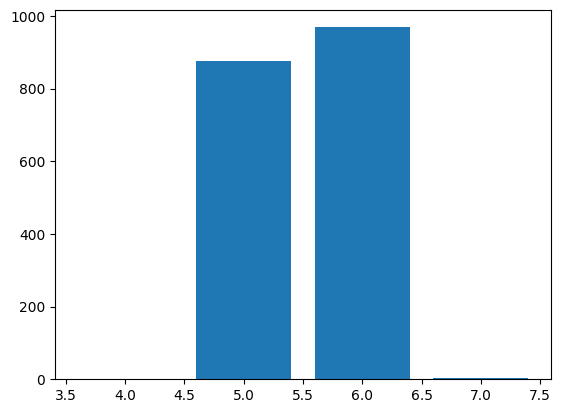

In [6]:
with open("../archives/example-problem.pkl", "rb") as f:
    problem = pickle.load(f)

example_data, _ = problem_to_cnf_graph(problem)

nx_graph = torch_geometric.utils.to_networkx(example_data, to_undirected=True)

g = pyvis.network.Network(width=1800, height=1000, cdn_resources='in_line')
g.toggle_hide_edges_on_drag = True
g.barnes_hut()
g.from_nx(nx_graph)
g.save_graph("example.html")

eccentricities = list(nx.eccentricity(nx_graph).values())
plt.bar(*np.unique(eccentricities, return_counts=True))

In [7]:
class CnfProcessingBlock(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, edge_dim: int, disambiguate_clauses: bool):
        super().__init__()

        self.disambiguate_clauses = disambiguate_clauses

        if disambiguate_clauses:
            self.conv_redundant = gnn.GATv2Conv(in_channels, out_channels, edge_dim=edge_dim, residual=True)
            self.conv_irredundant = gnn.GATv2Conv(in_channels, out_channels, edge_dim=edge_dim, residual=True)
        else:
            self.conv_clauses = gnn.GATv2Conv(in_channels, out_channels, edge_dim=edge_dim, residual=True)

        self.conv_variables = gnn.GATv2Conv(in_channels, out_channels, edge_dim=edge_dim, residual=True)

        self.activation = nn.ReLU(inplace=True)

    def forward(self, h, data):
        edge_index, edge_attr, node_type = data.edge_index, data.edge_attr, data.node_type

        out = torch.zeros_like(h)

        variable_mask = (node_type == NodeType.VARIABLE.value)
        out[variable_mask, :] = self.conv_variables(h, edge_index, edge_attr)[variable_mask, :]

        if self.disambiguate_clauses:
            redundant_mask = (node_type == NodeType.REDUNDANT.value)
            irredundant_mask = (node_type == NodeType.IRREDUNDANT.value)

            out[redundant_mask, :] = self.conv_redundant(h, edge_index, edge_attr)[redundant_mask, :]
            out[irredundant_mask, :] = self.conv_irredundant(h, edge_index, edge_attr)[irredundant_mask, :]
        else:
            clause_mask = (node_type != NodeType.VARIABLE.value)

            out[clause_mask] = self.conv_clauses(h, edge_index, edge_attr)[clause_mask, :]


        out = self.activation(out)

        return out

In [8]:
class ExpectedValueNormalization(torch.autograd.Function):
    @staticmethod
    def forward(ctx, p: torch.Tensor, ex: torch.Tensor):
        ex = torch.as_tensor(ex)

        gamma = torch.ones(p.shape[:-1], device=p.device)

        for _ in range(6):
            normalized = p ** gamma.unsqueeze(-1)
            f_gamma = normalized.sum(dim=-1) - ex
            f_prime_gamma = (normalized * p.log()).sum(dim=-1)
            gamma = gamma - f_gamma / f_prime_gamma

        normalized = p ** gamma.unsqueeze(-1)
        ctx.save_for_backward(p, normalized, gamma)
        return normalized

    @staticmethod
    def backward(ctx, grad_output):
        p, normalized, gamma = ctx.saved_tensors

        normalized_dp = normalized * p.log()
        denom = normalized_dp.sum(dim=-1)

        jac = (
            torch.diag_embed(gamma.unsqueeze(-1) * normalized / p) -
            (gamma / denom).unsqueeze(-1).unsqueeze(-1) * normalized_dp.unsqueeze(-2) * (normalized / p).unsqueeze(-1)
        )

        return (jac @ grad_output.unsqueeze(-1)).squeeze(-1), None


"""
x = torch.tensor([
    [1., 0.5, 0.5, 0.5, 0.1],
    [0.3, 0.5, 0.5, 0.8, 0.2],
], requires_grad=True)
optim = torch.optim.SGD([x], lr=0.1)
for _ in range(100):
    optim.zero_grad()
    y = ExpectedValueNormalization.apply(x, torch.tensor([2.0, 1.0]))
    loss = y.pow(3.0).sum()
    loss.backward()
    optim.step()
    print(x.sum(axis=1))
"""

'\nx = torch.tensor([\n    [1., 0.5, 0.5, 0.5, 0.1],\n    [0.3, 0.5, 0.5, 0.8, 0.2],\n], requires_grad=True)\noptim = torch.optim.SGD([x], lr=0.1)\nfor _ in range(100):\n    optim.zero_grad()\n    y = ExpectedValueNormalization.apply(x, torch.tensor([2.0, 1.0]))\n    loss = y.pow(3.0).sum()\n    loss.backward()\n    optim.step()\n    print(x.sum(axis=1))\n'

In [9]:
class CnfGraphModel(nn.Module):
    def __init__(
        self,
        input_global_dim: int,
        input_variable_dim: int,
        input_clause_dim: int,
        hidden_dims: list[int],
        disambiguate_clauses_in_first: int = 2,
        edge_dim: int = 1,
    ):
        super().__init__()

        self.input_variable_dim = input_variable_dim
        self.input_clause_dim = input_clause_dim

        self.variable_fc = nn.Linear(input_global_dim + input_variable_dim, hidden_dims[0])
        self.clause_fc = nn.Linear(input_global_dim + input_clause_dim, hidden_dims[0])

        self.silu = nn.SiLU()

        self.processing_blocks = nn.ModuleList([
            CnfProcessingBlock(
                hidden_dims[i],
                hidden_dims[i + 1],
                edge_dim,
                i < disambiguate_clauses_in_first
            )
            for i in range(len(hidden_dims) - 1)
        ])

        self.output_fc = nn.Linear(hidden_dims[-1], 1)

        self.value_fc_clauses = nn.Linear(hidden_dims[-1], 1)
        self.value_fc_variables = nn.Linear(hidden_dims[-1], 1)

    def forward(self, cnf_graph: CnfGraph, ex: torch.Tensor | float):
        logger.info("Starting model forward pass")

        num_vertices = cnf_graph.x.shape[0]
        variable_mask = (cnf_graph.node_type == NodeType.VARIABLE.value)
        num_variables = variable_mask.sum()

        variable_input = torch.cat([
            cnf_graph.global_data.expand(num_variables, -1),
            cnf_graph.x[:num_variables, :self.input_variable_dim],
        ], dim=-1)

        variable_embedding = self.silu(self.variable_fc(variable_input))

        clause_input = torch.cat([
            cnf_graph.global_data.expand(num_vertices - num_variables, -1),
            cnf_graph.x[num_variables:, :self.input_clause_dim],
        ], dim=-1)

        clause_embedding = self.silu(self.clause_fc(clause_input))

        x = torch.cat([variable_embedding, clause_embedding], dim=0)

        for block in self.processing_blocks:
            x = block(x, cnf_graph)

        logits = self.output_fc(x[cnf_graph.node_type == NodeType.REDUNDANT.value]).view(-1)
        probs = torch.sigmoid(logits)
        probs = ExpectedValueNormalization.apply(probs, ex)

        value_vars = self.value_fc_variables(x[variable_mask])
        value_clauses = self.value_fc_clauses(x[~variable_mask])
        value = torch.cat([value_vars, value_clauses]).mean()

        logger.info("Finished model forward pass")

        return probs, value

In [10]:
testing_model = CnfGraphModel(
    input_global_dim=DIM_INFO.num_global_features,
    input_variable_dim=DIM_INFO.num_var_features,
    input_clause_dim=DIM_INFO.num_clause_features,
    edge_dim=DIM_INFO.num_edge_features,
    hidden_dims=[32, 32, 32, 32],
)

testing_model(minimal_example_data, 0.75)

INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass


(tensor([0.3744, 0.3756], grad_fn=<ExpectedValueNormalizationBackward>),
 tensor(0.0798, grad_fn=<MeanBackward0>))

In [11]:
DEV = "cpu"
torch.set_float32_matmul_precision("medium")

In [12]:
@dataclasses.dataclass
class Hyperparameters:
    batch_size: int = 64
    learning_rate: float = 3e-4
    epochs: int = 4
    eps_clip: float = 0.2
    entropy_coef: float = 0.01
    value_weight: float = 0.5
    policy_weight: float = 1.0
    gae_gamma: float = 0.99
    gae_lambda: float = 0.95
    penalty_per_conflict: float = 5e-4


HP = Hyperparameters()


In [13]:
def compute_returns_advantages(rewards: list[float], values: list[float]) -> tuple[list[float], list[float]]:
    returns = []
    advantages = []
    gae = 0
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + HP.gae_gamma * (values[i + 1] if i + 1 < len(values) else 0) - values[i]
        gae = delta + HP.gae_gamma * HP.gae_lambda * gae
        returns.append(gae + values[i])
        advantages.append(gae)
    return returns[::-1], advantages[::-1]

In [14]:
@dataclasses.dataclass
class EpisodeResult:
    states: list[CnfGraph]
    dists: list[torch.distributions.Bernoulli]
    actions: list[torch.Tensor]
    rewards: list[float]
    values: list[float]
    returns: list[float]
    advantages: list[float]

    stats: list[dict]

    @staticmethod
    def empty() -> 'EpisodeResult':
        return EpisodeResult([], [], [], [], [], [], [], [])

    def merge_with(self, other: 'EpisodeResult') -> 'EpisodeResult':
        assert (
            len(self.states) == len(self.dists) == len(self.actions) ==
            len(self.values) == len(self.rewards) == len(self.returns) ==
            len(self.advantages)
        )
        assert (
            len(other.states) == len(other.dists) == len(other.actions) ==
            len(other.values) == len(other.rewards) == len(other.returns) ==
            len(other.advantages)
        )
        return EpisodeResult(
            self.states + other.states,
            self.dists + other.dists,
            self.actions + other.actions,
            self.rewards + other.rewards,
            self.values + other.values,
            self.returns + other.returns,
            self.advantages + other.advantages,
            self.stats + other.stats,
        )

    @staticmethod
    def merge_all(results: list['EpisodeResult']) -> 'EpisodeResult':
        result = results[0]
        for other in results[1:]:
            result = result.merge_with(other)
        return result

    def add(self, *, state, dist, action, reward, value):
        assert (
            len(self.states) == len(self.dists) == len(self.actions) ==
            len(self.values) == len(self.rewards)
        )
        self.states.append(state)
        self.dists.append(dist)
        self.actions.append(action)
        if reward is not None:
            self.rewards.append(reward)
        self.values.append(value)

    def add_reward(self, reward):
        assert (
            len(self.states) == len(self.dists) == len(self.actions) ==
            len(self.values) == len(self.rewards) + 1
        )
        self.rewards.append(reward)

    def complete(self, stats: dict):
        assert (
            len(self.states) == len(self.dists) == len(self.actions) ==
            len(self.values) == len(self.rewards)
        )
        assert len(self.stats) == 0
        self.returns, self.advantages = compute_returns_advantages(self.rewards, self.values)
        self.stats = [stats]


In [15]:
class Agent:
    def __init__(self, model):
        self.model = model.to(DEV)
        self.optim = torch.optim.Adam(self.model.parameters(), lr=HP.learning_rate)

    def act(self, cnf_graph: CnfGraph, ex: float):
        logger.info("Running agent act")
        with torch.no_grad():
            cnf_graph = cnf_graph.to(DEV)
            probs, value = self.model(cnf_graph, ex)
            logger.info("Finished agent act")
            return torch.distributions.Bernoulli(probs), value.item()

    def update(self, results: EpisodeResult):
        logger.info("Training agent")
        assert all(a.dtype == torch.bool for a in results.actions)
        r = results

        n = len(r.states)
        batch_size = HP.batch_size
        for num_epoch in range(HP.epochs):
            logger.info("Training agent, epoch %d", num_epoch)
            indices = random.sample(range(n), n)
            for batch_start in range(0, n, batch_size):
                idx = indices[batch_start:batch_start + batch_size]

                self.optim.zero_grad()
                for i in idx:
                    graph, ex = r.states[i]
                    new_probs, value = self.model(graph, ex)
                    value = value.cpu()
                    dist = torch.distributions.Bernoulli(probs=new_probs)
                    log_probs = dist.log_prob(r.actions[i].float())
                    entropy = dist.entropy().sum()

                    ratio = torch.exp(log_probs - r.dists[i].log_prob(r.actions[i].float()))
                    surr1 = ratio * r.advantages[i]
                    surr2 = torch.clamp(ratio, 1.0 - HP.eps_clip, 1.0 + HP.eps_clip) * r.advantages[i]

                    value_loss = torch.nn.functional.mse_loss(value, torch.tensor(r.rewards[i] + r.values[i]))
                    policy_loss = -torch.min(surr1, surr2).mean()

                    loss = (
                        HP.policy_weight * policy_loss
                        + HP.value_weight * value_loss
                        - HP.entropy_coef * entropy
                    ) / len(idx)

                    loss.backward()

                self.optim.step()

In [16]:
testing_agent = Agent(testing_model)

states = [
    (minimal_example_data, 0.75),
    (minimal_example_data, 0.5),
    (minimal_example_data, 0.25),
]

dist1, value1 = testing_agent.act(*states[0])
dist2, value2 = testing_agent.act(*states[1])
dist3, value3 = testing_agent.act(*states[2])

dists = [dist1, dist2, dist3]
values = [value1, value2, value3]
print(values)

actions = [dist.sample() > 0.5 for dist in dists]
rewards = [-1.0, -1.0, 10.0]

returns, advantages = compute_returns_advantages(rewards, [1.0, 1.0, 1.0])
print(advantages)

results = EpisodeResult(
    states,
    dists,
    actions,
    rewards,
    values,
    returns,
    advantages,
    [],
)

testing_agent.update(results)


INFO:notebook:Running agent act
INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass
INFO:notebook:Finished agent act
INFO:notebook:Running agent act
INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass
INFO:notebook:Finished agent act
INFO:notebook:Running agent act
INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass
INFO:notebook:Finished agent act
INFO:notebook:Training agent
INFO:notebook:Training agent, epoch 0
INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass
INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass
INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass
INFO:notebook:Training agent, epoch 1
INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass
INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass


[0.07984636723995209, 0.07984636723995209, 0.07984636723995209]
[6.00095725, 7.4544999999999995, 9.0]


INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass
INFO:notebook:Training agent, epoch 2
INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass
INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass
INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass
INFO:notebook:Training agent, epoch 3
INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass
INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass
INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass


In [17]:
@dataclasses.dataclass
class CnfProblemInstance:
    result: bool
    path: Path
    stats: dict[str, any]
    stats_no_reductions: dict[str, any]


with open("../archives/runs.json", "r") as f:
    runs = [json.loads(line) for line in f.readlines()]
    runs = [CnfProblemInstance(
        result=run["result"],
        path=Path(run["path"]),
        stats=run["stats"],
        stats_no_reductions=run["stats_no_reductions"],
    ) for run in runs]


def get_random_instance(unsat_only: bool = True):
    while True:
        run = random.choice(runs)
        if not unsat_only or not run.result:
            return run

In [18]:
class CadicalEnv:
    def __init__(
        self,
        cadical_path: Path,
        num_parallel: int = 2,
        runs_per_episode: int = 16,
    ):
        self.cadical_path = cadical_path
        self.num_parallel = num_parallel
        self.runs_per_episode = runs_per_episode
        self.semaphore = asyncio.Semaphore(num_parallel)

    async def run_instance(self, agent: Agent, instance_path: Path) -> EpisodeResult:
        result = EpisodeResult.empty()
        router = runner.Router()

        reduce_number = 0
        last_conflicts = 0

        @router.route("reduce")
        async def _reduce_route(conn: runner.Connection, info: runner.RunInfo, _data):
            nonlocal reduce_number
            nonlocal last_conflicts

            logger.info("Received clause database reduction")

            num_vars = await conn.read_u64()
            levels = [-1] * num_vars
            vals = [-1] * num_vars
            for i in range(num_vars):
                vals[i] = await conn.read_i8()
                levels[i] = await conn.read_i32()
            num_clauses = await conn.read_u64()
            clauses = [await conn.read_clause() for _ in range(num_clauses)]
            num_reducible = await conn.read_u64()
            num_target = await conn.read_u64()
            reducible_ids = [await conn.read_u64() for _ in range(num_reducible)]
            conflicts = await conn.read_u64()
            await conn.write_ok()

            if reduce_number != 0:
                result.add_reward(-(conflicts - last_conflicts) * HP.penalty_per_conflict)
            last_conflicts = conflicts

            problem = ReductionProblem(
                num_vars=num_vars,
                levels=levels,
                vals=vals,
                clauses=clauses,
                reducible_ids=reducible_ids,
            )

            logger.debug("Finished reading reduction data")

            cnf, dim_info = problem_to_cnf_graph(problem)
            assert dim_info == DIM_INFO
            
            ex = float(num_target)

            logger.debug("Converted problem to CNF graph")

            dist, value = agent.act(cnf, ex)
            action = dist.sample()

            logger.debug("Agent acted")

            result.add(
                state=(cnf, ex),
                dist=dist,
                action=action,
                reward=None,
                value=value,
            )

            logger.debug("Results are written to replay buffer")

            reducible_ids = ordered_reducible_ids(problem)

            to_reduces = []
            for id_, a in zip(reducible_ids, action):
                if a > 0.5:
                    to_reduces.append(id_)

            logger.debug("Sending reduction data")

            await conn.write_u32(len(to_reduces))
            for id_ in to_reduces:
                await conn.write_u64(id_)

            reduce_number += 1

        @router.route("stats")
        async def _stats_route(conn: runner.Connection, info: runner.RunInfo, data):
            nonlocal last_conflicts
            
            logger.info("Received stats")
            stats = {}
            while (name := await conn.read_str()) != "end":
                if name == "time":
                    stats[name] = await conn.read_f64()
                else:
                    stats[name] = await conn.read_u64()
            await conn.write_ok()
            result.add_reward(-(stats["conflicts"] - last_conflicts) * HP.penalty_per_conflict)
            result.complete(stats)

        await runner.run_instance(
            self.cadical_path,
            ["--reduce-mode", "2"],
            instance_path,
            router.routes,
            silent=False,
            semaphore=self.semaphore,
        )
        
        return result

    async def run_episode(self, agent: Agent) -> EpisodeResult:
        tasks = []
        for _ in range(self.runs_per_episode):
            instance = get_random_instance()
            tasks.append(self.run_instance(agent, instance.path))

        results = await asyncio.gather(*tasks)
        return EpisodeResult.merge_all(results)


In [21]:
logging.basicConfig(level=logging.WARNING)
logger.setLevel(logging.WARNING)

model = CnfGraphModel(
    input_global_dim=DIM_INFO.num_global_features,
    input_variable_dim=DIM_INFO.num_var_features,
    input_clause_dim=DIM_INFO.num_clause_features,
    edge_dim=DIM_INFO.num_edge_features,
    hidden_dims=[32, 32, 32, 32],
)

agent = Agent(model)

env = CadicalEnv(
    Path("../cadical/build/cadical"),
    num_parallel=1,
    runs_per_episode=16,
)

for episode in range(100):
    print(f"Episode {episode}: ", end="")
    results = await env.run_episode(agent)
    agent.update(results)
    print(f"Rewards: {sum(results.rewards)}")


INFO:runner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-f9cdd599-df60-45ad-8137-8747b3d706f7.cnf
INFO:runner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/ab2367c0-594c-496a-90b0-4cd7a15be3ab.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-f9cdd599-df60-45ad-8137-8747b3d706f7.cnf
DEBUG:runner:Starting connection to /tmp/ab2367c0-594c-496a-90b0-4cd7a15be3ab.sock
DEBUG:runner:Server started
DEBUG:runner:Connection established


Episode 0: c --- [ banner ] -------------------------------------------------------------
c 
c CaDiCaL SAT Solver
c Copyright (c) 2016-2024 A. Biere, M. Fleury, N. Froleyks, K. Fazekas, F. Pollitt
c 
c Version 2.1.0 b4b761ce97ca8060c3d5b9f374a089db7e1d8a73
c g++ (Ubuntu 13.2.0-23ubuntu4) 13.2.0 -Wall -Wextra -O3 -DNDEBUG
c Fri Dec 6 20:23:29 MSK 2024 Linux melon 6.8.0-49-generic x86_64
c 
c --- [ limit ] --------------------------------------------------------------
c 
c setting time limit to 1000000000 seconds real time (due to '-t 1000000000')
c 
c --- [ parsing input ] ------------------------------------------------------
c 
c reading DIMACS file from '/home/elt/projects/sat-rl-exploration/instances/unif-f9cdd599-df60-45ad-8137-8747b3d706f7.cnf'
c opening file to read '/home/elt/projects/sat-rl-exploration/instances/unif-f9cdd599-df60-45ad-8137-8747b3d706f7.cnf'
c found 'p cnf 241 1036' header
c parsed 1036 clauses in 0.00 seconds process time
c 
c --- [ options ] -----------------

Failed to read value from connection


CancelledError: 